# Compressing Images using Clustering

In this workshop we'll learn about compressing images using
k-means clustering.  Image are stored as arrays of 32 bit
numbers with 3, 8 bit integers allocated to R, G, and B color
channels.  The last 8 bit value is usually dedicated to 
a transparency or alpha channel.  

With this storage scheme, we're able to store 256 different values 
for each color channel, and represent $256^3 = 2^{24} = 16777216$ 
unique colors.  If we think of each pixel as a data point, we can 
reduce this to $k$ unique colors by clustering our pixels and using
the cluster centroids as our colors.  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 300

## Images

We've got some images here with a variety of colors:

In [5]:
from skimage.io import imread

forest = imread("./imgs/forest.jpg")
nyc = imread("./imgs/nyc.jpg")
pond = imread("./imgs/tropical-pond.jpg")

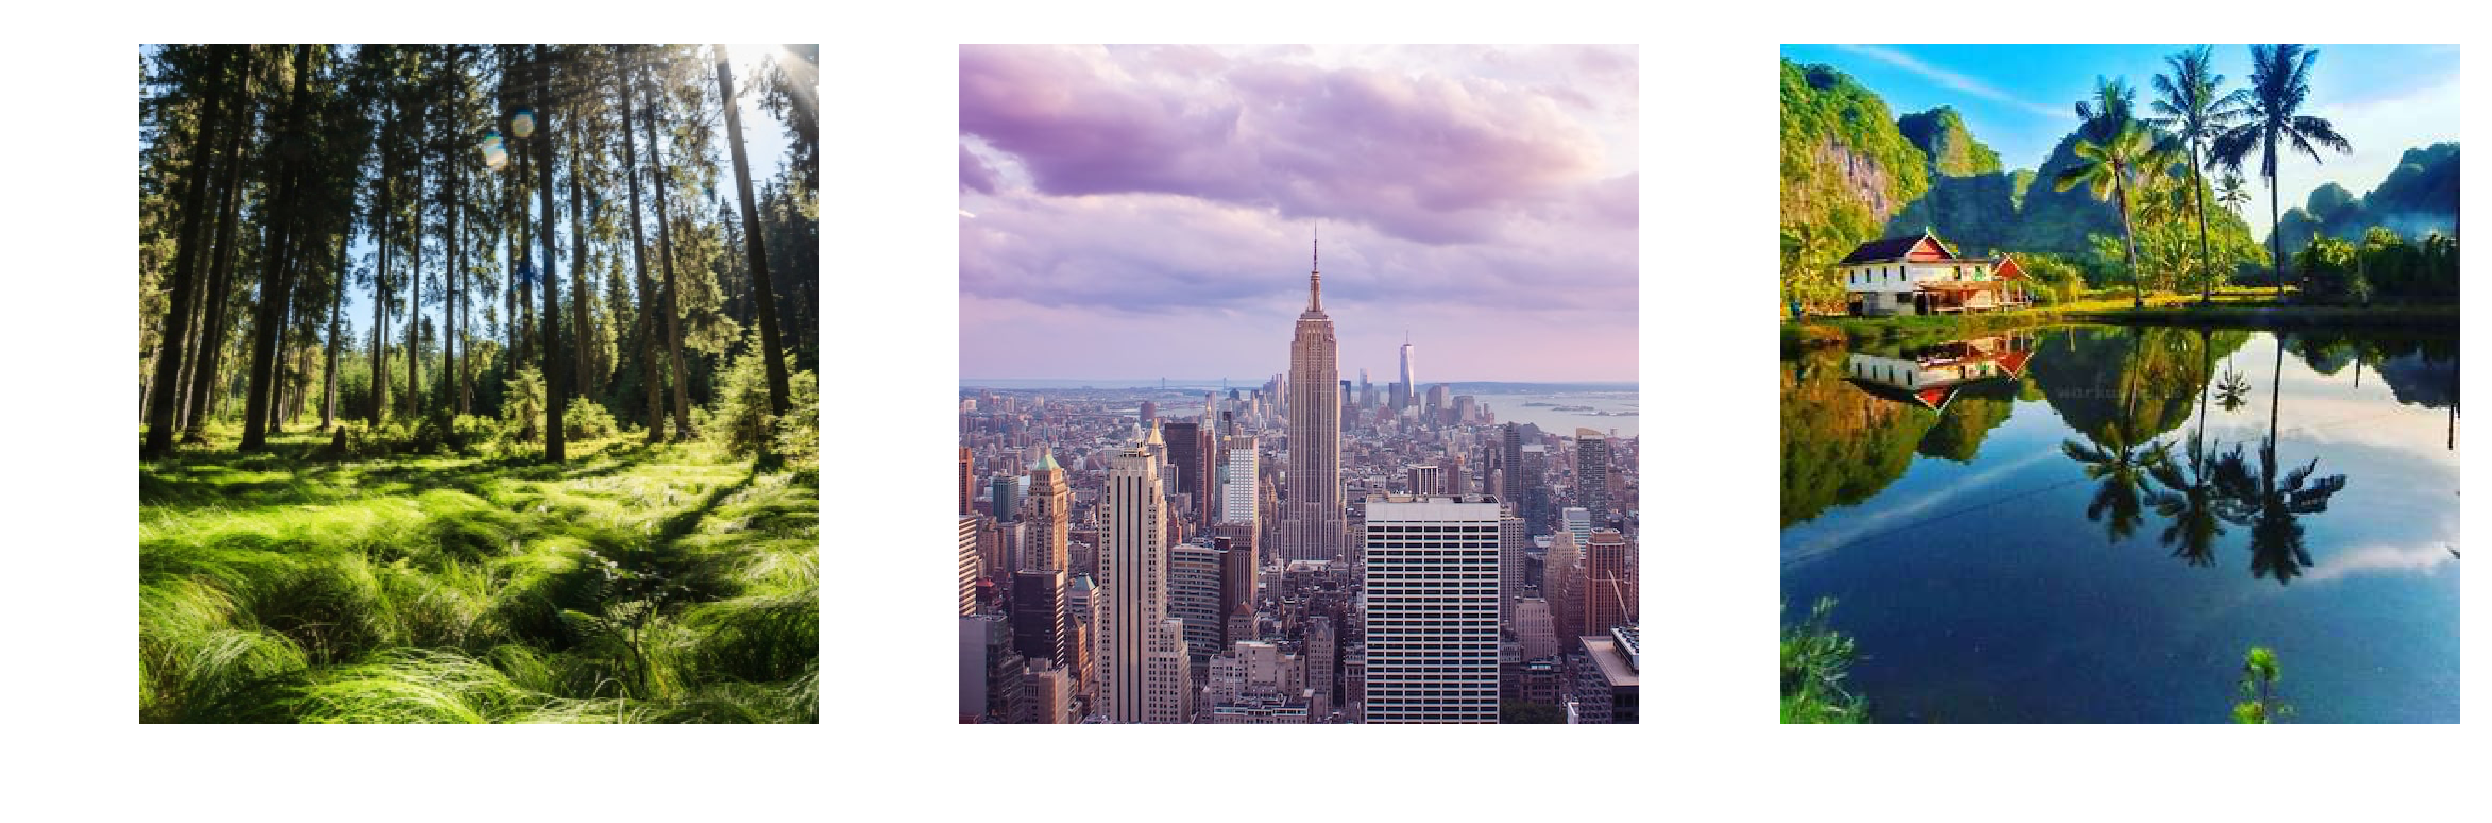

In [13]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(131)
ax.axis("off")
plt.imshow(forest)
ax = plt.subplot(132)
ax.axis("off")
plt.imshow(nyc)
ax = plt.subplot(133)
ax.axis("off")
plt.imshow(pond)

## Inspecting some our pixel data

In [14]:
from sklearn.decomposition import PCA

data = np.vstack((img.reshape((-1, 3)) for img in [forest, nyc, pond]))

We can inspect our pixels in a 2d plot by projecting 
them onto the first 2 principal components.

In [44]:
pca = PCA(n_components=2)
datapc = pca.fit_transform(data)

datapc.shape

(704289, 2)

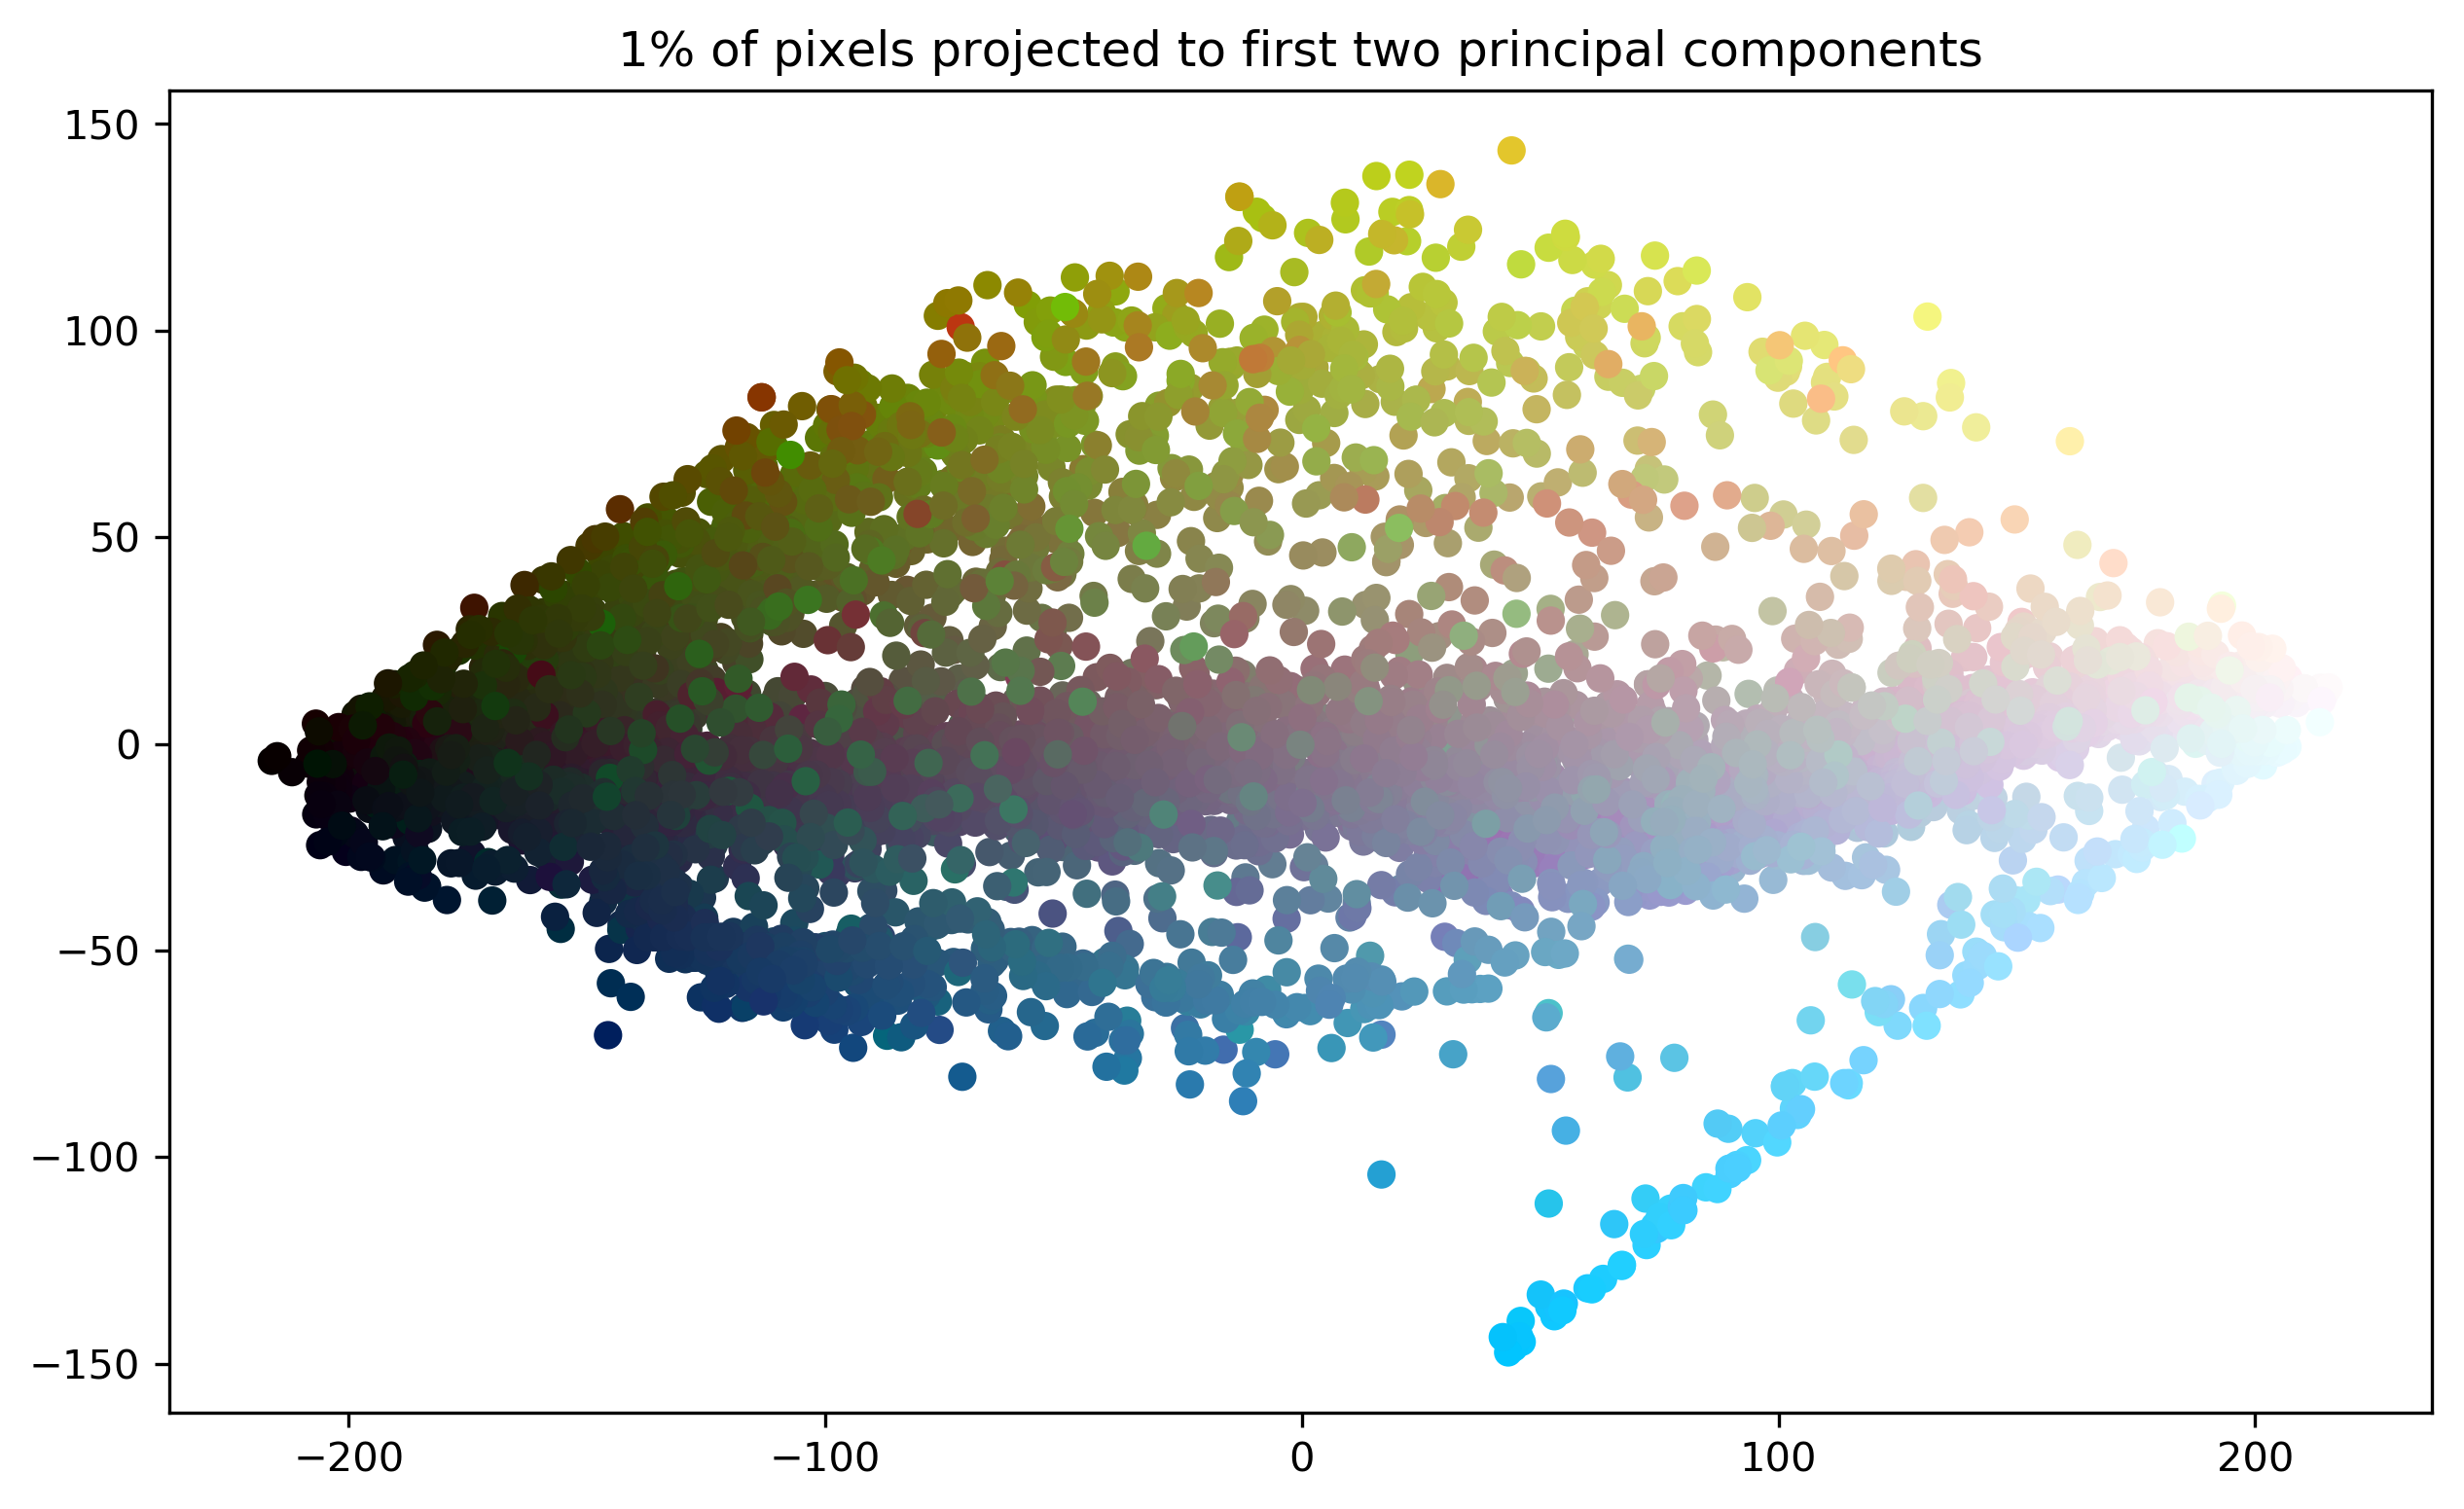

In [45]:
plt.scatter(*datapc[::100].T, c=(data[::100] / 255))
plt.title("1% of pixels projected to first two principal components")
plt.show()

## k-means clustering

We'll now implement [$k$-means clustering](https://en.wikipedia.org/wiki/K-means_clustering).
The algorithm is iterative with two main steps:

Assignment: Assign each data observation to the cluster with the nearest centroid.

* calculate distance between all points and all clusters (nested for loop or `scipy.spatial.distance.cdist`)
* assign each point to closest cluster (`np.argmin`)

Update: Update the cluster centers to be the mean of all points belonging to the cluster.

* `np.mean` of points belonging to cluster `i`

In [25]:
from scipy.spatial.distance import cdist

class KMeans(object):
    """
    KMeans class designed to emulate sklearn's KMeans interface.
    """
    
    def __init__(self, n_clusters = None, n_init = 10, max_iter = 300,
                 tol = 1e-4):
        """
        Constructor to get us going.  Set's several parameters to be
        used later.
        :param n_clusters: number of clusters to look for
        :param n_init: number of times to restart the algorithm, the result
                       of the best run in terms of inertia is recorded
        :param max_iter: the maximum number of iterations to run
        :param tol: the relative tolerance at which to stop at in 
                    terms of inertia
        """
        
        self.n_clusters_ = n_clusters
        self._n_init = n_init
        self._max_iter = max_iter
        self._tol = tol
        
    def fit(self, X):
        """
        Compute's the k-means clustering of X, randomly intializing
        the algorithm self._n_init number of times.
        """
        
        best = (None, None, np.inf)
        for run in range(self._n_init):
            self._fit_once(X)
            run_data = (self.cluster_centers_, self.labels_, self.inertia_)
            best = run_data if run_data[2] < best[2] else best
            
        self.cluster_centers_, self.labels_, self.inertia_ = best
        return self
            
    def _fit_once(self, X):
        """
        Internal helper method to run K-means once. Used by self.fit
        """
      
        # set the initial cluster centers to several random points
        # in our data matrix
        num_samples = X.shape[0]
        init_cluster_points = np.random.choice(
            num_samples, self.n_clusters_, False
        )
       
        # perform initial cluster assignment
        self.cluster_centers_ = X[init_cluster_points, :]
        self.labels_ = self.predict(X)
        self.inertia_ = self._calc_inertia(X)
        
        # loop setup
        prev_inertia = self.inertia_ - 10 # just something to start off
        iteration = 1
       
    
        while (np.abs(self.inertia_ - prev_inertia) >= self._tol and
               iteration < self._max_iter):

            self.labels_ = self.predict(X)
            # new centers
            self.cluster_centers_ = np.array(
                [np.mean(X[self.labels_ == ind], axis = 0) 
                 for ind in range(self.n_clusters_)
                 if ind in self.labels_]
            )
            prev_inertia = self.inertia_
            self.inertia_ = self._calc_inertia(X)
            iteration += 1
            
        return self
    
    def _calc_inertia(self, X):
        """
        Calculates the inertia given the cluster assignments and data.
        Inertia is defined as the:
        
            Sum of squared distances of samples to their closest cluster center.
        """
       
        return cdist(X, self.cluster_centers_, 'euclidean').min(axis = 1
                                                               ).sum()
        
    def predict(self, X):
        """
        Predicts the cluster assignment of all points in X using 
        self.cluster_centers_.
        
        X: [n x d matrix]
        self.cluster_centers_: [self.num_clusters_ x d matrix]
        """
        
        point_dist = cdist(X, self.cluster_centers_, 'euclidean')
        return np.argmin(point_dist, axis=1)

In [26]:
km = KMeans(n_clusters=128, n_init=1)
km.fit(data)

# Visualizing the pixels and images

We'll use the same technique to display the cluster centers, as well
as plot the new quantized images.

In [62]:
def plot_quantized_pixels(data, pca, kmeans, skip=100):
    
    datapc = pca.transform(data)
    
    for clustnum in range(kmeans.n_clusters_):
        plt.scatter(*datapc[kmeans.labels_ == clustnum][::skip].T, 
                    c = kmeans.cluster_centers_[clustnum] / 255)

    plt.title("Color Quantization using {} code words".format(kmeans.n_clusters_))
    plt.show()

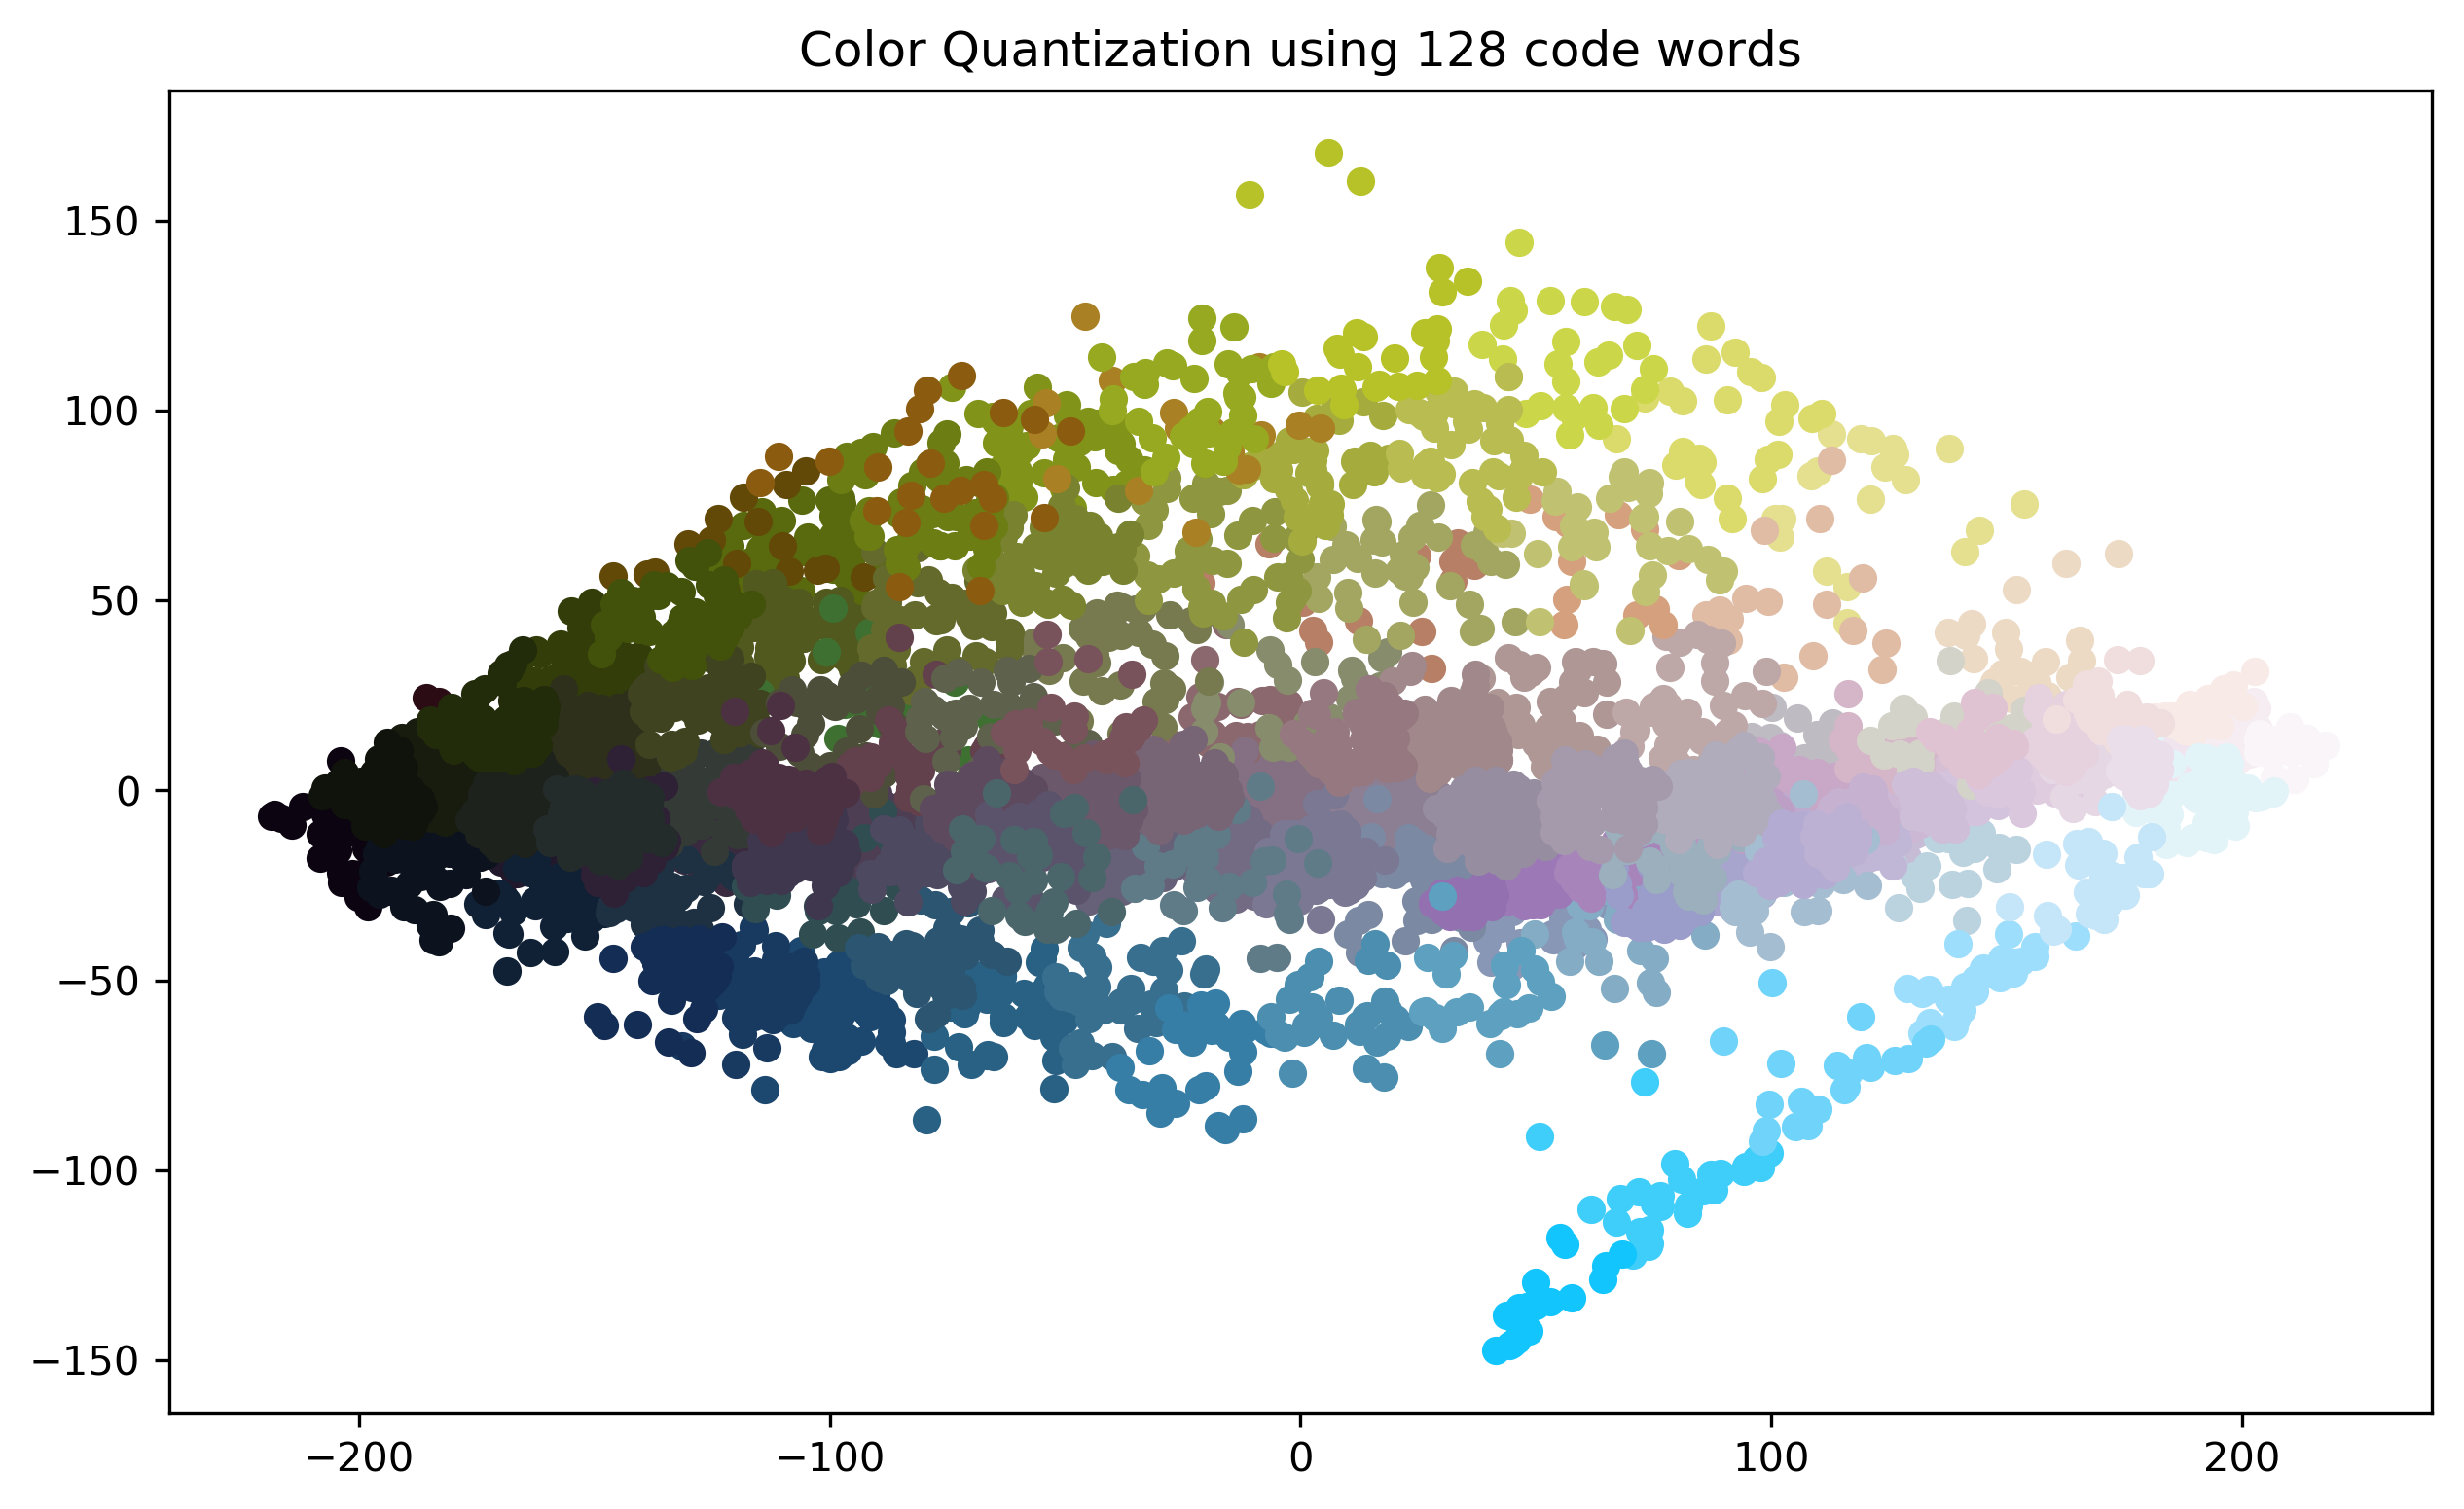

In [63]:
plot_quantized_pixels(data, pca, km)

In [60]:
from matplotlib.gridspec import GridSpec

def plot_quantized_image(img, kmeans, ax=None, title=None):
    pixels = img.reshape((-1, 3))
    quantized_img = kmeans.cluster_centers_[kmeans.predict(pixels).reshape((img.shape[0], img.shape[1]))] / 255
    
    if ax is None:
        ax = plt.figure().gca()
    
    ax.imshow(quantized_img)
    ax.axis('off')
    if title:
        ax.set_title(title)

def plot_quantized_images(imgs, kmeans):
    
    gs = GridSpec(1, len(imgs))
    
    for i, img in enumerate(imgs):
        plot_quantized_image(img, kmeans, ax=plt.subplot(gs[0, i]))

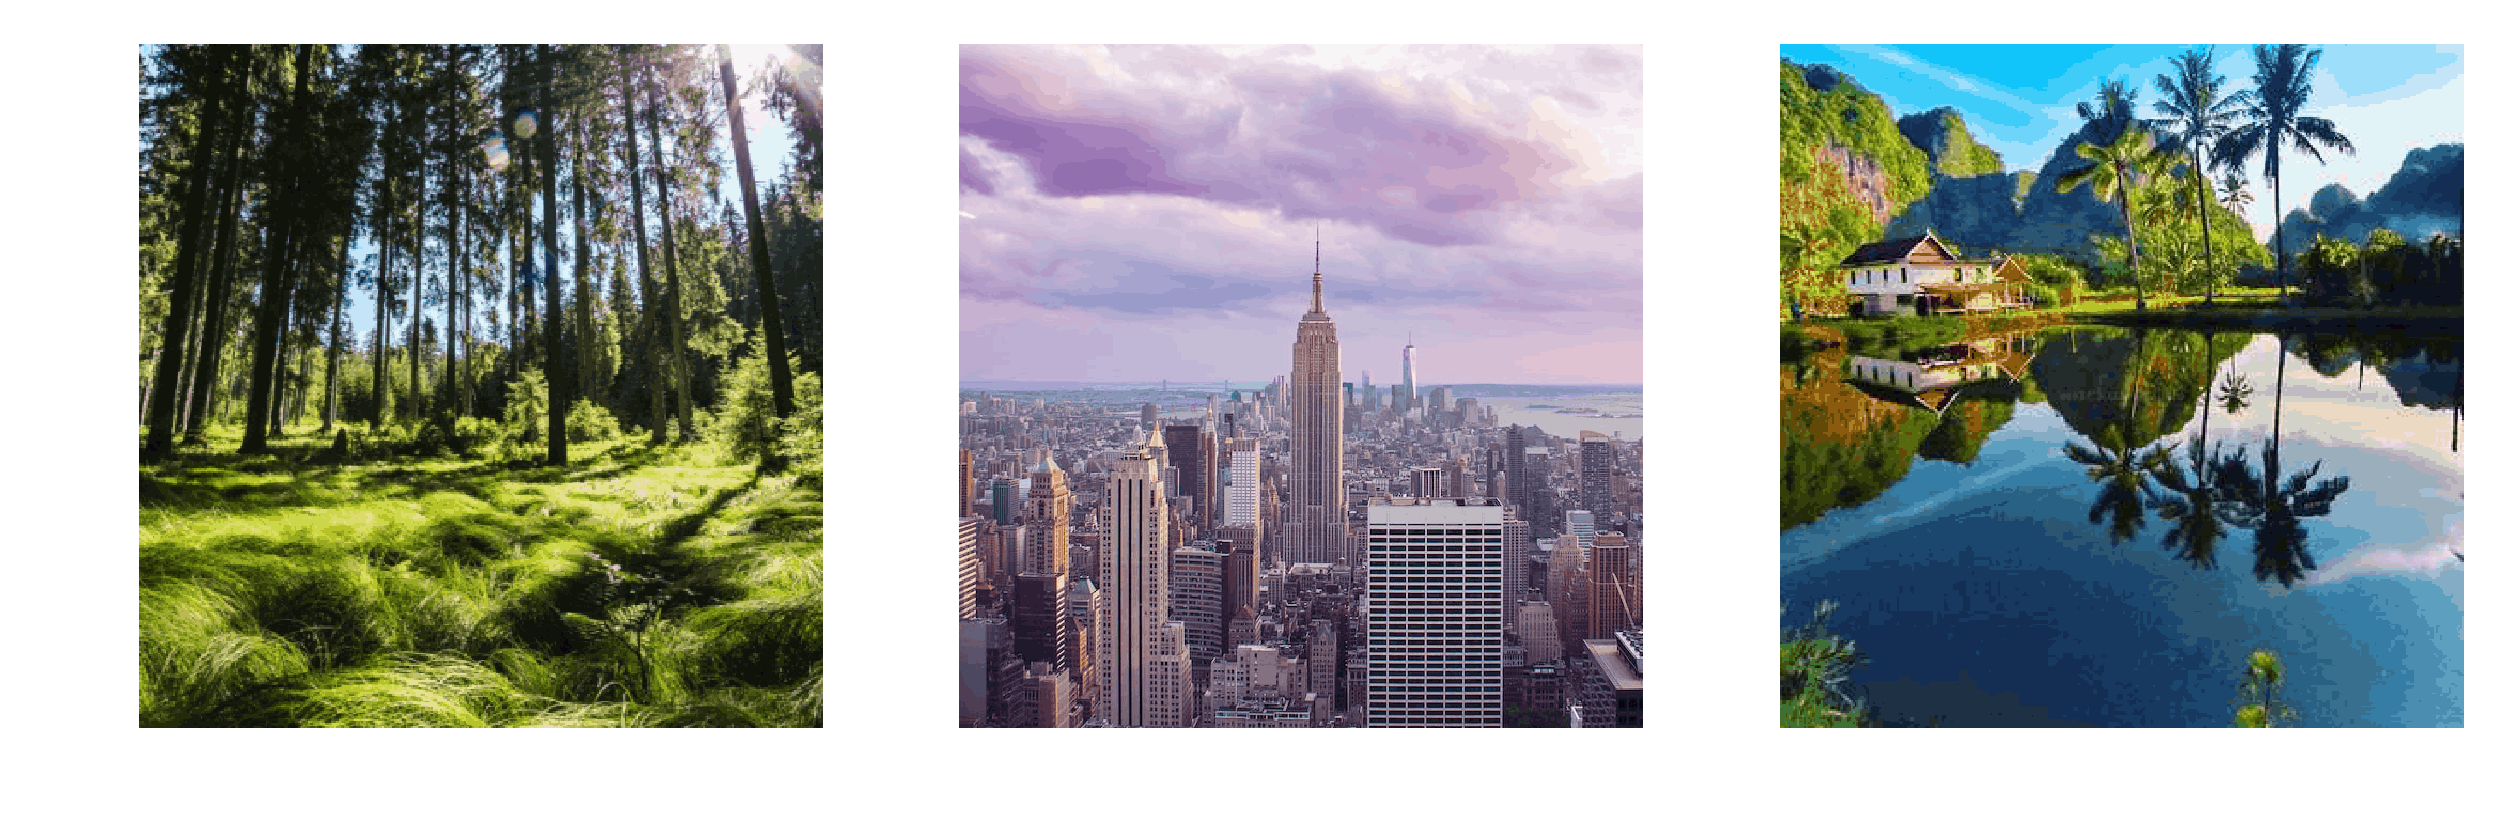

In [61]:
plot_quantized_images([forest, nyc, pond], km)